In [1]:
#import necessary dependecies
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import os
import warnings
import numpy as np  
import seaborn as sns
import pandas as pd, os, gc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline
warnings.filterwarnings('ignore')
from typing import List

In [2]:
#Data Path

trains=pd.read_csv('Train.csv')
tests=pd.read_csv('Test.csv')
submissions=pd.read_csv('SampleSubmission.csv')

In [3]:
#print all dataset shape
print(trains.shape, tests.shape,submissions.shape)

(29132, 29) (10000, 29) (210000, 2)


In [4]:
train = trains
test = tests
submission = submissions

In [5]:
#Store Products ID in Multidimensional array
products =train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
products_t =test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

In [6]:
#Axis Transformation
train = train.melt(id_vars=train.columns[:8], value_vars=products, var_name = "PCODE", value_name="Label" )
test = test.melt(id_vars=test.columns[:8], value_vars=products, var_name = "PCODE", value_name="Label" )

In [7]:
#A merger
train['combiner']='x'

In [8]:
#Set
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [9]:
#preview random 3 sample
data.sample(3)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,Label,combiner
505975,9J8NZNT,1/5/2019,M,M,1984,E5SW,3NHZ,L44T,JZ9D,0,x
724304,H1LCKYL,1/12/2018,F,M,1999,94KC,6PE7,T4MS,AHXO,0,NaN
179993,ZJ94MWJ,1/6/2019,M,M,1984,UAOD,2A7I,T4MS,SOP4,0,x


In [10]:
#Confirm Distribution (TEST AND SAMPLE SUBMISSION FILE)
print('==' * 18);print('TRAIN LABEL DISTRIBUTION');print('==' * 18);print(train['Label'].value_counts())
print('==' * 18);print('TEST LABEL DISTRIBUTION');print('==' * 18);print(test['Label'].value_counts())
print('==' * 18);print('SAMPLE SUBMISSION LABEL DISTRIBUTION');print('==' * 18);print(submission['Label'].value_counts())

TRAIN LABEL DISTRIBUTION
0    545419
1     66353
Name: Label, dtype: int64
TEST LABEL DISTRIBUTION
0    197147
1     12853
Name: Label, dtype: int64
SAMPLE SUBMISSION LABEL DISTRIBUTION
0    197147
1     12853
Name: Label, dtype: int64


In [11]:
train=data[data.combiner.notnull()].reset_index(drop=True);test=data[data.combiner.isna()].reset_index(drop=True)
train.drop('combiner', inplace=True, axis=1);test.drop(['Label','combiner'], inplace=True, axis=1)
print(train.shape, test.shape, submission.shape)

(611772, 10) (210000, 9) (210000, 2)


In [12]:
#Concatenate new column towards submission requirement
train['ID X PCODE'] = train['ID'] + ' X ' + train['PCODE'];test['ID X PCODE'] = test['ID'] + ' X ' + test['PCODE']

In [13]:
#Re-arrange column (not necessary)
train=train[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE',  'Label']]
test=test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE']]

In [14]:
#Lets Check for data co-existence in Train/Test
for col in ['PCODE','occupation_code', 'branch_code','occupation_category_code']:
    train_col = train[col].unique();test_col = test[col].unique()
    print ('Not in Test ' + col + ' ',[i  for i in train_col if i not in test_col])
    print ('Not in Train ' + col + ' ',[i  for i in test_col  if i not in train_col]);print('==' * 30)

Not in Test PCODE  []
Not in Train PCODE  []
Not in Test occupation_code  ['IE90', 'Q0LY', 'JSAX', '6XXU', '8HRZ', 'OQMY', 'INEJ', 'VZN9', 'UC7E', 'PSUY', 'WSRG', 'JQH3', 'LGTN', '738L', 'QQUP', '2XZ1', 'CAAV', 'LLLH', 'W1X2', 'DHSN', 'IX8T', '2US6', 'ZWPL', 'MEFQ', '9B5B', 'JUIP', 'BFD1', 'A4ZC', 'IMHI', 'E5PF', 'GZA8', '3YQ1', 'PJR4', 'NDL9', 'PPNK', '2686', '5LNN', '374O', 'URYD', 'M0WG', 'KBWO', 'ONY7', 'VYSA', 'KUPK', 'R7GL', 'HSVE', 'BER4', '6SKY', 'RH2K', 'ZHC2', 'W3ZV', 'FLXH', 'UYDZ', 'YJXM', '59QM']
Not in Train occupation_code  ['0ZND', '8CHJ', '9F96', 'HSI5', '93OJ', 'BIA0', 'E2MJ', 'JBJP', '0FOI']
Not in Test branch_code  []
Not in Train branch_code  []
Not in Test occupation_category_code  []
Not in Train occupation_category_code  []


In [15]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0


In [16]:
# LABEL ENCODE
def encode_LE(train,test,cols,verbose=True):
    for col in cols:
        df_comb = pd.concat([train[col],test[col]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        nm = col
        if df_comb.max()>32000: 
            train[nm] = df_comb[:len(train)].astype('int32')
            test[nm] = df_comb[len(train):].astype('int32')
        else:
            train[nm] = df_comb[:len(train)].astype('int16')
            test[nm] = df_comb[len(train):].astype('int16')
        del df_comb; x=gc.collect()
        if verbose: print(nm,', ',end='')

In [17]:
encode_LE(train, test, ['ID','branch_code', 'occupation_code','occupation_category_code','PCODE','sex','marital_status'])

ID , branch_code , occupation_code , occupation_category_code , PCODE , sex , marital_status , 

In [18]:
train.nunique()

ID                           29132
join_date                      132
sex                              2
marital_status                   8
birth_year                      61
branch_code                     15
occupation_code                233
occupation_category_code         6
PCODE                           21
ID X PCODE                  611772
Label                            2
dtype: int64

In [19]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE
0,16566,1/12/2018,1,2,1984,4,96,1,15,F86J5PC X P5DA
1,18664,1/10/2019,1,2,1996,0,128,1,15,H6141K3 X P5DA
2,29677,1/1/2020,0,7,1968,11,19,5,15,RBAYUXZ X P5DA
3,22120,1/2/2019,1,2,1989,4,19,5,15,KCBILBQ X P5DA
4,23700,1/2/2020,0,2,1982,11,3,5,15,LSEC1ZJ X P5DA


In [20]:
final_train = train.iloc[:, :9]

In [21]:
final_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE
0,5384,1/2/2019,0,2,1987,0,19,5,15
1,13834,1/6/2019,0,2,1981,11,19,5,15
2,3217,1/6/2013,1,6,1991,3,185,1,15
3,3010,1/8/2019,1,2,1990,0,82,0,15
4,12546,1/8/2019,1,2,1990,3,157,5,15


In [22]:
final_train.to_csv('final.csv')

In [23]:
final = pd.read_csv('final.csv')
final.columns

Index(['Unnamed: 0', 'ID', 'join_date', 'sex', 'marital_status', 'birth_year',
       'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'],
      dtype='object')

In [24]:

final_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE
0,5384,1/2/2019,0,2,1987,0,19,5,15
1,13834,1/6/2019,0,2,1981,11,19,5,15
2,3217,1/6/2013,1,6,1991,3,185,1,15
3,3010,1/8/2019,1,2,1990,0,82,0,15
4,12546,1/8/2019,1,2,1990,3,157,5,15


In [25]:
final.head()

,Unnamed: 0,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE
0,0,5384,1/2/2019,0,2,1987,0,19,5,15
1,1,13834,1/6/2019,0,2,1981,11,19,5,15
2,2,3217,1/6/2013,1,6,1991,3,185,1,15
3,3,3010,1/8/2019,1,2,1990,0,82,0,15
4,4,12546,1/8/2019,1,2,1990,3,157,5,15


In [26]:
final_train.reset_index(drop=True, inplace=True)

In [27]:
final_train.nunique()

ID                          29132
join_date                     132
sex                             2
marital_status                  8
birth_year                     61
branch_code                    15
occupation_code               233
occupation_category_code        6
PCODE                          21
dtype: int64

In [28]:
final.nunique()

Unnamed: 0                  611772
ID                           29132
join_date                      132
sex                              2
marital_status                   8
birth_year                      61
branch_code                     15
occupation_code                233
occupation_category_code         6
PCODE                           21
dtype: int64

In [29]:

final_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE
0,5384,1/2/2019,0,2,1987,0,19,5,15
1,13834,1/6/2019,0,2,1981,11,19,5,15
2,3217,1/6/2013,1,6,1991,3,185,1,15
3,3010,1/8/2019,1,2,1990,0,82,0,15
4,12546,1/8/2019,1,2,1990,3,157,5,15


In [30]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE
0,16566,1/12/2018,1,2,1984,4,96,1,15,F86J5PC X P5DA
1,18664,1/10/2019,1,2,1996,0,128,1,15,H6141K3 X P5DA
2,29677,1/1/2020,0,7,1968,11,19,5,15,RBAYUXZ X P5DA
3,22120,1/2/2019,1,2,1989,4,19,5,15,KCBILBQ X P5DA
4,23700,1/2/2020,0,2,1982,11,3,5,15,LSEC1ZJ X P5DA


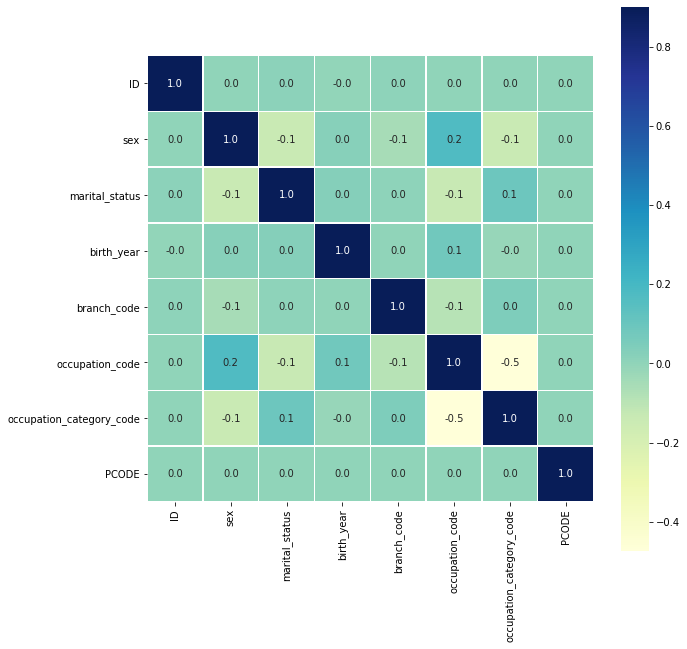

In [31]:
SpearmanCorr = final_train.corr(method="spearman")
plt.figure(figsize=(10,10))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

In [32]:
final_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE
0,5384,1/2/2019,0,2,1987,0,19,5,15
1,13834,1/6/2019,0,2,1981,11,19,5,15
2,3217,1/6/2013,1,6,1991,3,185,1,15
3,3010,1/8/2019,1,2,1990,0,82,0,15
4,12546,1/8/2019,1,2,1990,3,157,5,15
